In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [2]:
import sqlite3

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_62_00/icarus_data/database/ChannelMapICARUS.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df

def get_channel_id(db, board, digitizer_channel):
    
    ch = db.loc[(db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel), ['channel_id']]
    # print(board, ",", digitizer_channel, "-->", ch.values[0][0])

    return ch.values[0][0]

def get_PMT_id(db, channels):
     
    if np.isscalar(channels):
        pmt_id = db[db.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ db[db.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids

#------------------------------------------------------------------
# help function to parse the board name from the file

def get_board_label(filename):
    
    head, tail = os.path.split(filename)
    buf = tail.removesuffix(".fcl").removeprefix("icaruspmt")
    geo = buf[0:2]
    pos = buf[2:-2]
    slot = buf[-2:]
  
    if slot == "01":
        slot = "A"
    elif slot == "02":
        slot = "B"
    elif slot == "03":
        slot = "C"

    board_label = geo.upper() + "-" + pos.upper() + "-" + slot
    
    return board_label

#-------------------------------------------------------------------
# read baselines from config file

def editFile( filename, baselines ):
    
	readfile = open( filename, 'r' )
	board_label = get_board_label(filename)
	map = readSqlitedb()

	for line in readfile:

		line = line.strip()

		if "BaselineCh" in line:
        
			argline = line.split(".")[-1]
			buff = argline.split(":")		
			digitizer_channel = int(buff[0].split("Ch")[-1]) #these go from 1 to 16
			old_bl = int(buff[1])
            
			if (digitizer_channel != 16): #last digitizer channel has no pmt
                
				channel_id = get_channel_id(map, board_label, digitizer_channel-1) #in db, expected 0 to 15
				baselines[channel_id] = old_bl  #save for later threshold computation
                                
	readfile.close()
	return baselines

In [3]:
### PLOT BASELINE FOR EACH EVENT: shows how much spread during time evolution as a histogram
### plots all channels in the same board
def plot_channel_baselines(df, db, board):
    
    print("Board: " + board)
    fig = plt.figure(figsize=(25,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
    for digch in range(15):
        
        ch = get_channel_id(db,board,digch)
        column_name = "baseline_ch" + str(ch)
        ax = fig.add_subplot(4,4,digch+1)
    
        ax.hist( df[column_name], bins=200, range=(np.mean(df[column_name])-100,np.mean(df[column_name])+100), label="Channel {:d}\nMean: {:.1f}".format(ch,np.mean(df[column_name])) , histtype='step', lw=2)
        ax.legend()
        
    fig.supxlabel("Baseline [ADC]",fontsize=16)
    #fig.supylabel("# events")
    plt.tight_layout()

In [4]:
### PLOT BASELINE TIME EVOLUTION: shows time evolution for channels of the same board
### all channels from the same board in the same plot
def plot_baseline_evolution(df, db, board):
    
    timestamps = df["timestamp"].to_numpy()
    time = [datetime.fromtimestamp(t).strftime('%H:%M') for t in timestamps]
    
    for digch in range(15):

        ch = get_channel_id(db,board,digch)
        column_name = "baseline_ch" + str(ch)
        label_name = "Ch " + str(ch)
        
        plt.plot(time,df[column_name],label=label_name)

    plt.xlabel("Time")
    plt.ylabel("Baseline [ADC]")
    plt.title(board)
    plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right")
    plt.tight_layout()
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [5]:
### PLOT BASELINE FOR EACH CHANNEL: averaged over the first 20 events in each channel (as seen, not much evolution)
def plot_baseline_spread(df, setting, run, xman, xmin, xbins):
    
    baselines = []
    for ch in range(360):
        col = "baseline_ch" + str(ch)
        bs = df[col].head(20).to_numpy()
        baselines.append(np.median(bs))
        
    plt.hist(baselines, bins=xbins, range=(xmin,xmax), histtype='bar', lw=2, label="Mean: {:.1f}\nStd: {:.1f}".format(np.mean(baselines),np.std(baselines)))
    plt.xlabel("Baseline [ADC]")
    plt.ylabel("# channels")
    plt.title("Baseline spread at start (first 20 events) - Run " + str(run))
    
    plt.axvline(x=setting, color="red", linestyle='dotted')
    
    plt.grid()
    plt.legend()
    plt.savefig("plots/baselines_startRun"+str(run)+".pdf")
    plt.savefig("plots/baselines_startRun"+str(run)+".png")
    plt.show()

## Run 9463 - no calibration at all
> `CalibOnConfig = false`
> `LockTempCalibration = true`
> `AdcCalibration = false`

In [6]:
file = "../runs/9463/measChannelBaselines_run9463.csv"
run = 9463

meas_bs = pd.read_csv(file, sep=',')
db = readSqlitedb()   
boards = db["digitizer_label"].to_numpy()
boards = np.unique(boards)

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
#for board in boards:
#    plot_channel_baselines(meas_bs, db, board)
plot_channel_baselines(meas_bs, db, boards[0])

In [ ]:
setting = 14744
xmin = 14700
xmax = 15300
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

## Run 9410 - no first calibration
> `CalibOnConfig = false`
> `LockTempCalibration = false`
> `AdcCalibration = true`

In [ ]:
file = "../runs/9410/measChannelBaselines_run9410.csv"
run = 9410

meas_bs = pd.read_csv(file, sep=',')
db = readSqlitedb()   
boards = db["digitizer_label"].to_numpy()
boards = np.unique(boards)

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 14744
xmin = 14700
xmax = 15300
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

## Run 9451 - normal configuration
> `CalibOnConfig = true`
> `LockTempCalibration = false`
> `AdcCalibration = true`

In [10]:
file = "../runs/9451/measChannelBaselines_run9451.csv"
run = 9451

meas_bs = pd.read_csv(file, sep=',')
db = readSqlitedb()   
boards = db["digitizer_label"].to_numpy()
boards = np.unique(boards)

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 14744
xmin = 14700
xmax = 15300
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

## Run 9453 - disable temperatura calibration
> `CalibOnConfig = true`
> `LockTempCalibration = true`
> `AdcCalibration = true`

In [8]:
file = "../runs/9453/measChannelBaselines_run9453.csv"
run = 9453

meas_bs = pd.read_csv(file, sep=',')
db = readSqlitedb()   
boards = db["digitizer_label"].to_numpy()
boards = np.unique(boards)

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 14744
xmin = 14700
xmax = 15300
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

In [ ]:
file = "../runs/9434/measChannelBaselines_run9434.csv"
run = 9434

meas_bs = pd.read_csv(file, sep=',')

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 14744
xmin = 14700
xmax = 15300
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

# Run 9468 - pedestals to 13108

In [ ]:
file = "../runs/9468/measChannelBaselines_run9468.csv"
run = 9468

meas_bs = pd.read_csv(file, sep=',')

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 13107
xmin = 13000
xmax = 13600
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

# Run 9469 - setting baselines after calibration

In [ ]:
file = "../runs/9469/measChannelBaselines_run9469.csv"
run = 9469

meas_bs = pd.read_csv(file, sep=',')

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 14744
xmin = 14700
xmax = 15300
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

# Run 9471 - pedestal at mid DAC range

In [ ]:
file = "../runs/9471/measChannelBaselines_run9471.csv"
run = 9471

meas_bs = pd.read_csv(file, sep=',')

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 8192
xmin = 7900
xmax = 8500
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

In [ ]:
file = "../runs/9470/measChannelBaselines_run9470.csv"
run = 9470

meas_bs = pd.read_csv(file, sep=',')

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 8192
xmin = 7900
xmax = 8500
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

# Random

In [ ]:
from scipy.optimize import curve_fit

def line(x,a,b):
    return a*x+b

#points at 6554:
y6554 = np.array([14972., 14895., 14917., 14994.])
ymed6554 = np.mean(y6554)
print(ymed6554)

diff = np.amax(y6554)-np.amin(y6554)
print(diff)

x = np.array([ 6554., 13108., 32767.])
y = np.array([ ymed6554, 13289., 8162.])

p, covariance = curve_fit(line, x, y)

a = p[0]
b = p[1]
print(a,b)

plt.errorbar(x,y,xerr=None,yerr=diff/2.,ls='none',marker="o",label="Measured mean baseline")
plt.plot(x, a*x+b, label="y = a*x+b\na:{:.2f} b: {:.1f}".format(a,b))

a_exp = -16383./65535.
b_exp = 16383
plt.plot(x, line(x,a_exp,b_exp), ls="--", color="r", label="Expected setting\na:{:.2f} b: {:.1f}".format(a_exp,b_exp))

plt.xlabel("DAC setting [0 - 65535]")
plt.ylabel("Measured mean baseline [ADC]")

#plt.xlim((0,14000))
#plt.ylim((12000,16000))

plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(6.4, 1.6)) 
plt.errorbar(x, a*x+b-line(x,a_exp,b_exp),xerr=None,yerr=diff/2.,ls="dotted",marker="o")
plt.axhline(y=0, color="black", linestyle='dashed')
plt.grid()
plt.xlabel("DAC setting [0 - 65535]")
plt.ylabel("Difference between\nset and meas [ADC]")
plt.show()


In [ ]:
#points at 6554:
y6554 = np.array([91.8, 96.9, 95.1, 93.7])
ymed6554 = np.mean(y6554)
print(ymed6554)

diff = np.amax(y6554)-np.amin(y6554)
print(diff)

x = np.array([ 6554., 13108., 32767.])
y = np.array([ ymed6554, 75.3, 41.7])

p, covariance = curve_fit(line, x, y)

a = p[0]
b = p[1]
print(a,b)

plt.figure(figsize=(6.4, 2.4)) 
plt.errorbar(x,y,xerr=None,yerr=diff/2.,ls='none',marker="o",label="Baseline spread")
plt.plot(x, a*x+b, label="y = a*x+b\na:{:.3f} b: {:.1f}".format(a,b))
plt.ylabel("Baseline spread\n(standard dev) [ADC]")
plt.xlabel("DAC setting [0 - 65535]")
plt.grid()
plt.legend()

# Run 9479 - no baseline settings (defaults)

In [ ]:
file = "../runs/9479/measChannelBaselines_run9479.csv"
run = 9479

meas_bs = pd.read_csv(file, sep=',')

In [ ]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

In [ ]:
setting = 8192
xmin = 7900
xmax = 8500
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

# Run 9569 - post baseline "calibration"

In [11]:
file = "../runs/9569/measChannelBaselines_run9569.csv"
run = 9569

meas_bs = pd.read_csv(file, sep=',')

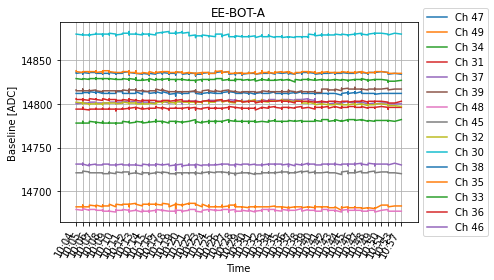

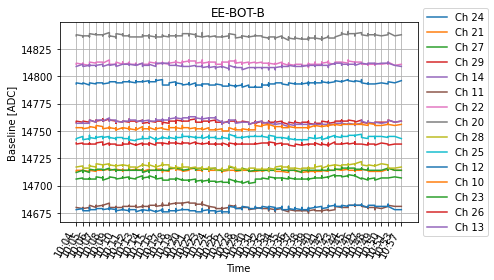

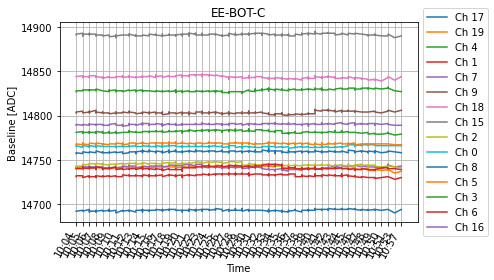

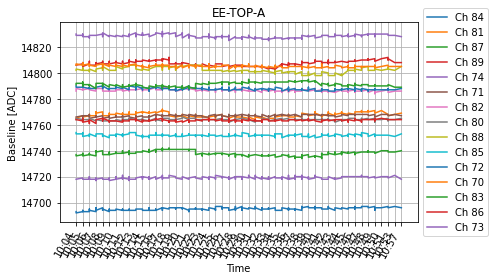

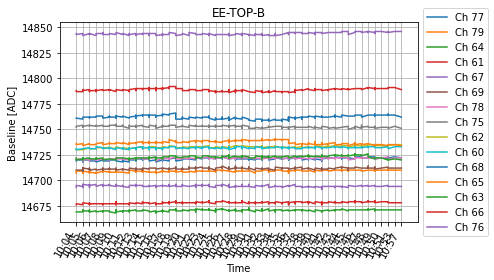

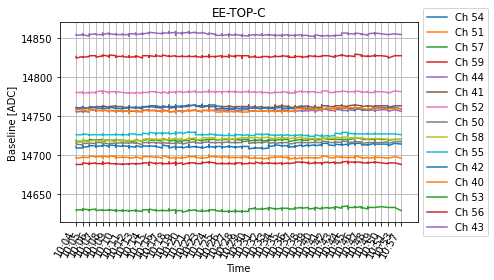

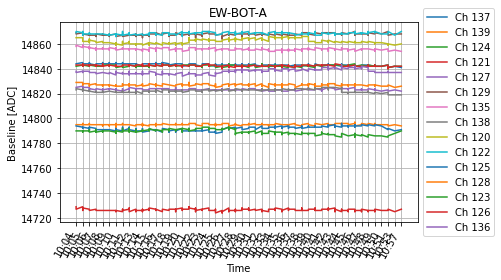

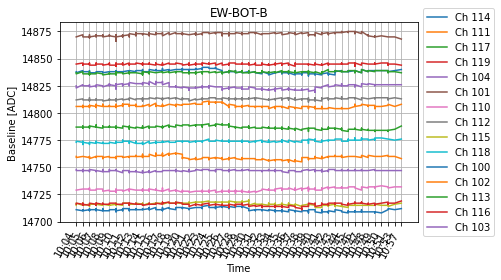

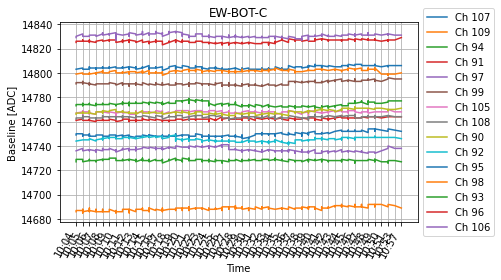

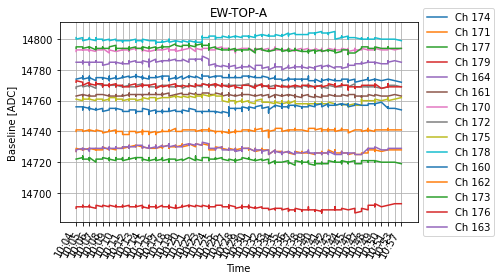

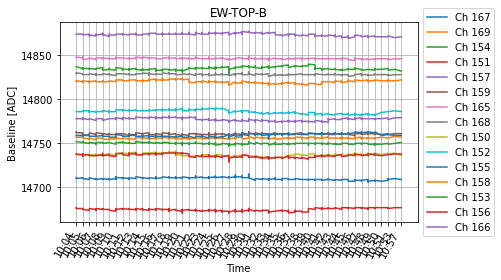

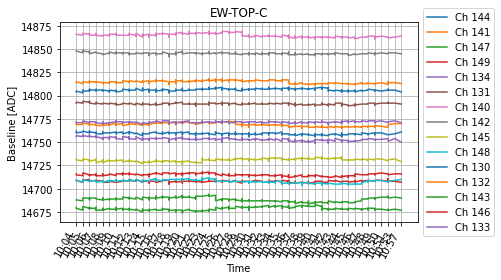

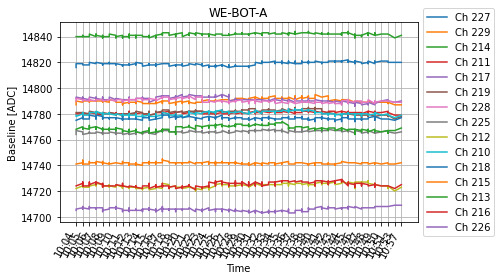

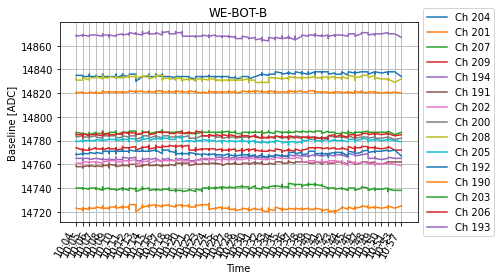

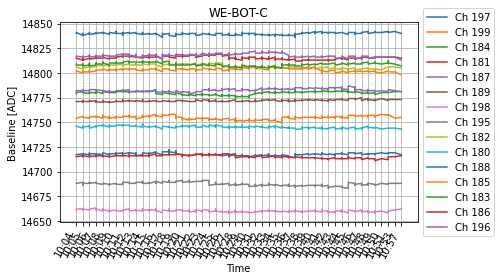

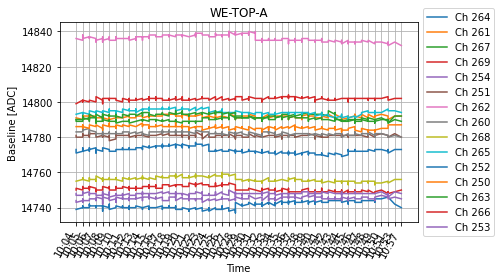

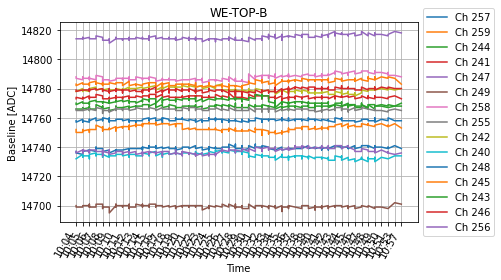

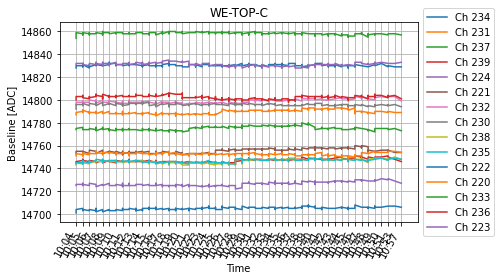

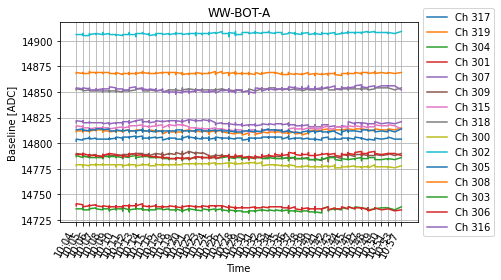

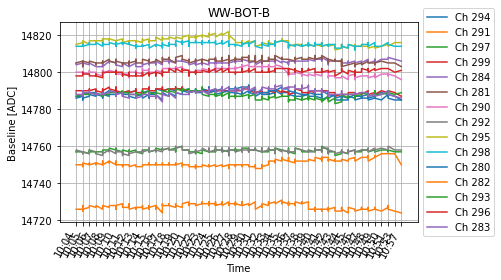

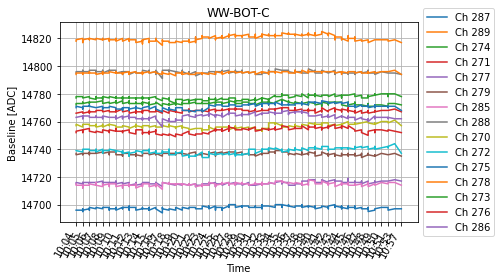

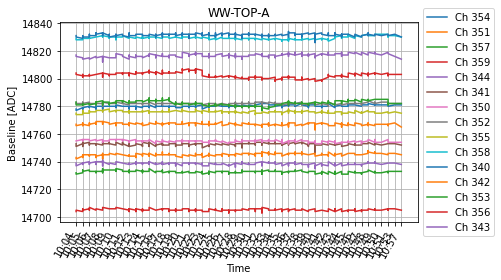

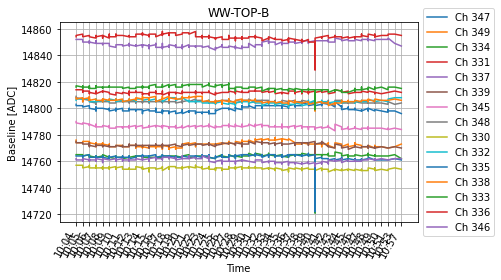

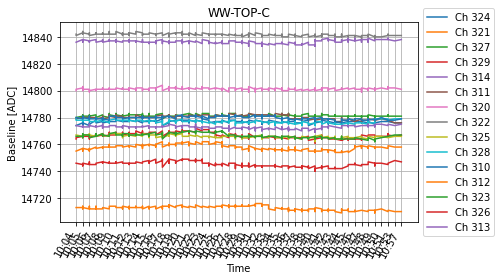

In [12]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

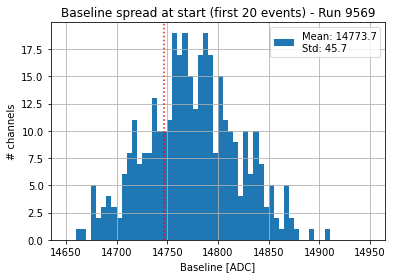

In [16]:
setting = 14747
xmin = 14650
xmax = 14950
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

## Run 9583 - Post new calibrations\

In [9]:
file = "../runs/9583/measChannelBaselines_run9583.csv"
run = 9583

meas_bs = pd.read_csv(file, sep=',')

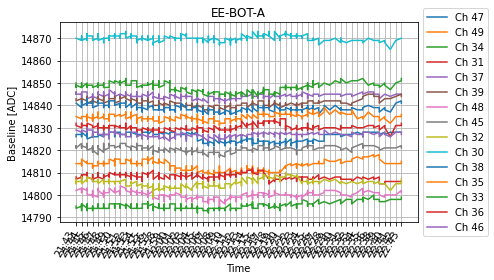

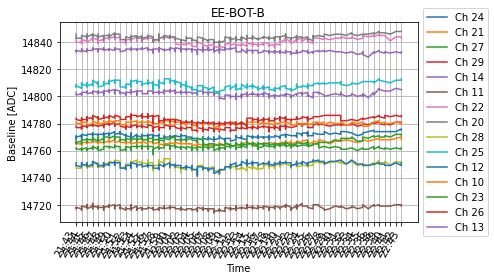

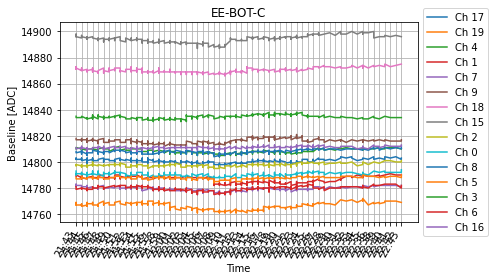

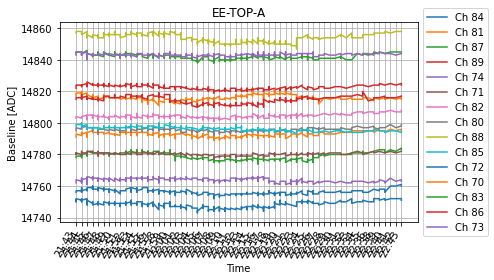

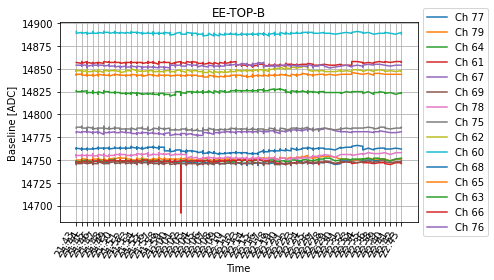

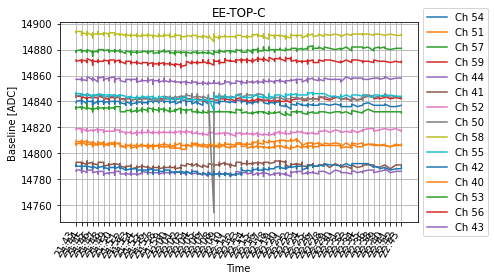

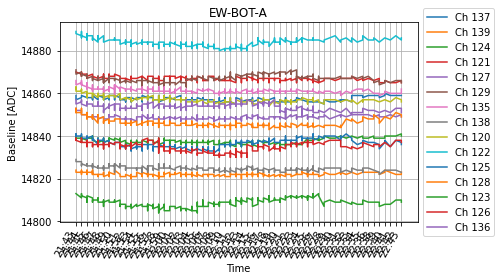

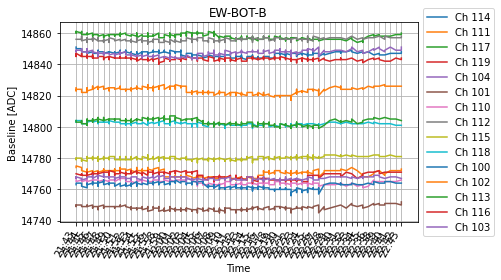

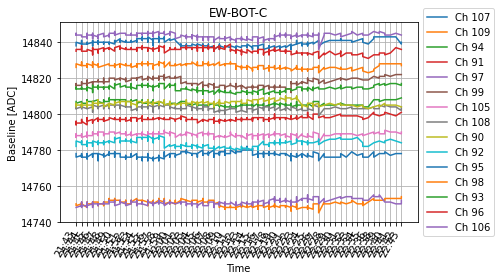

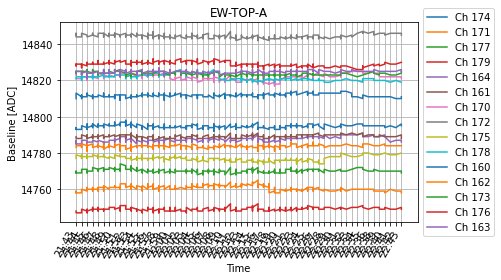

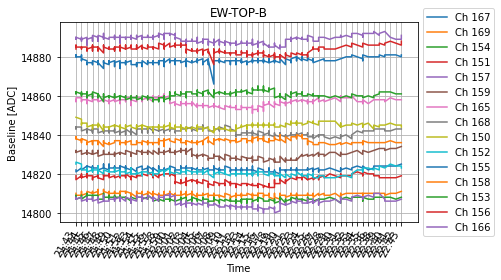

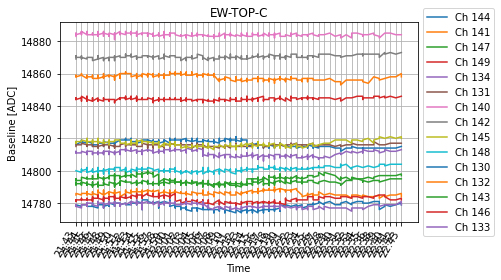

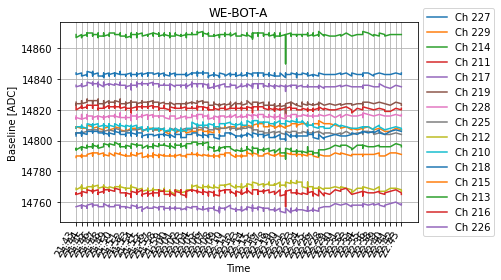

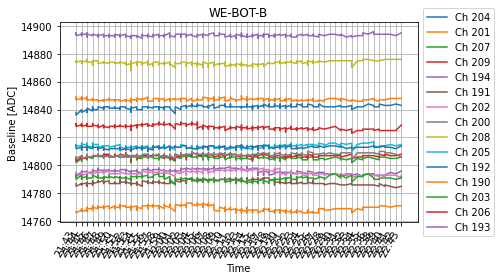

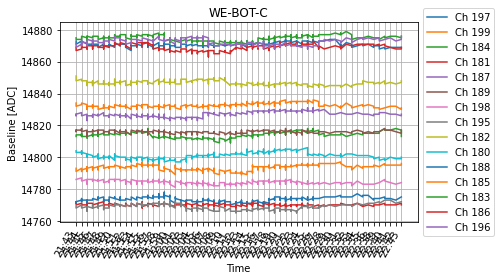

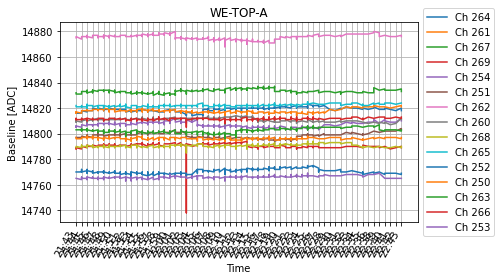

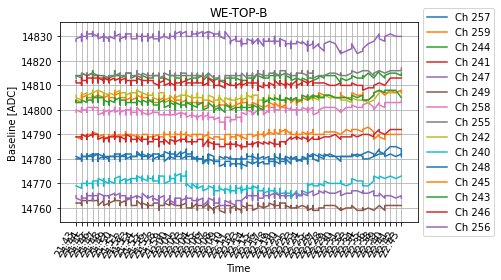

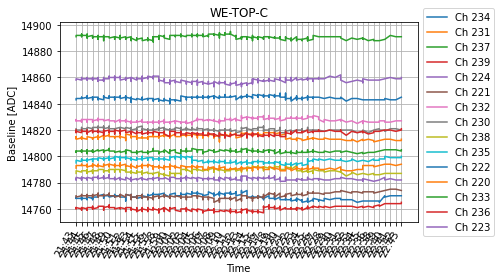

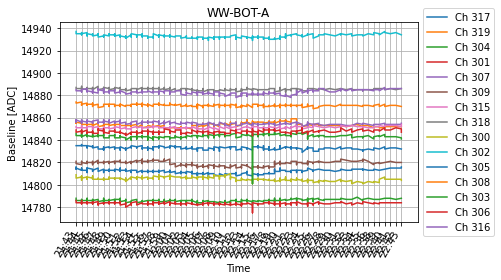

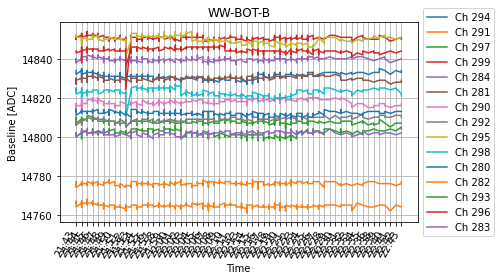

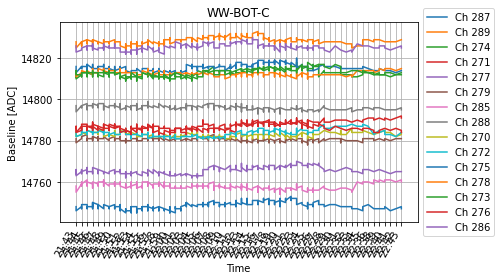

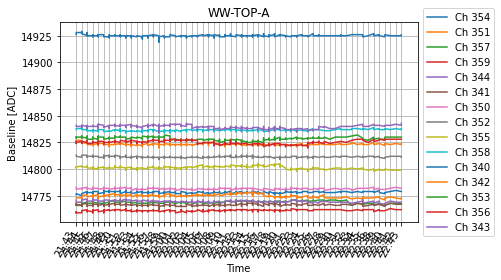

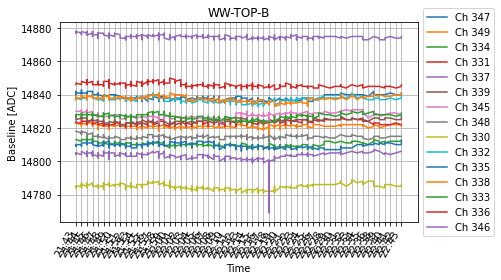

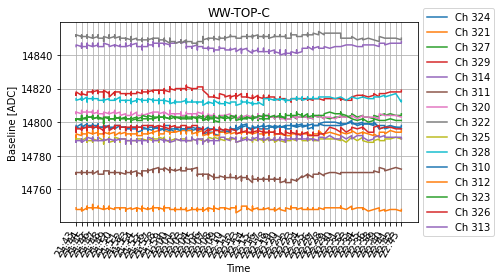

In [10]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

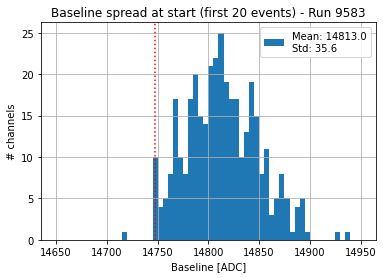

In [11]:
setting = 14747
xmin = 14650
xmax = 14950
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)

In [7]:
file = "../runs/9587/measChannelBaselines_run9587.csv"
run = 9587

meas_bs = pd.read_csv(file, sep=',')

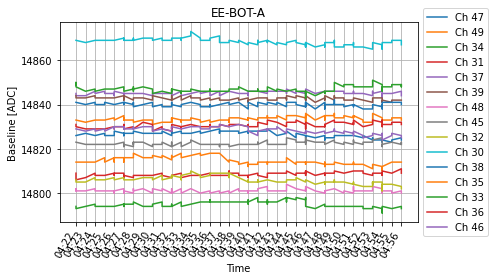

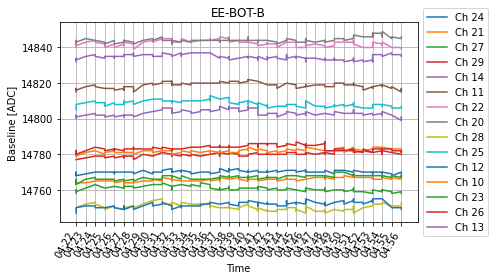

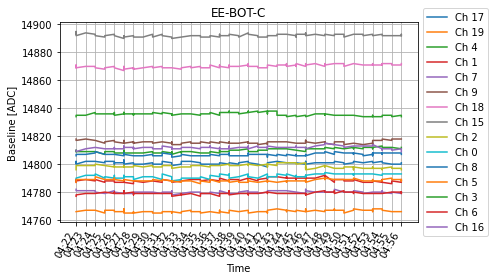

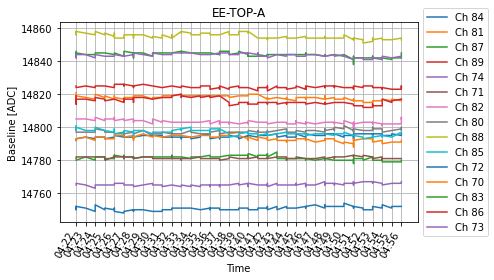

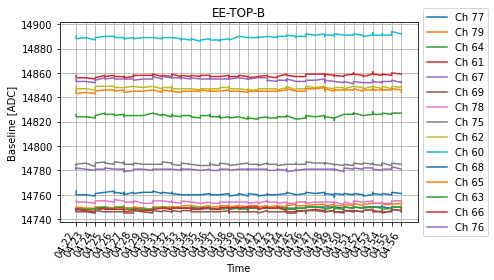

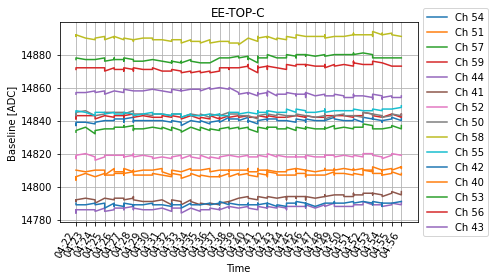

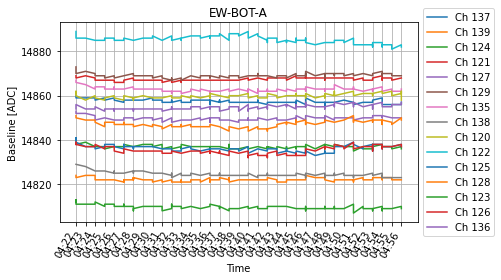

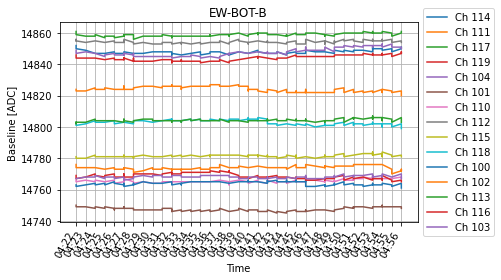

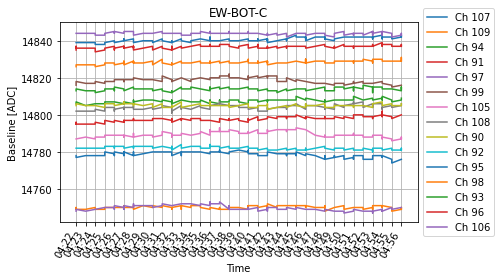

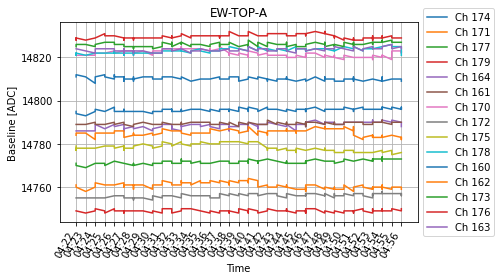

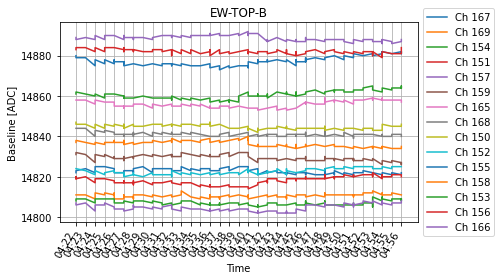

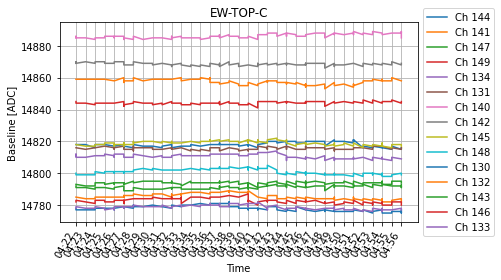

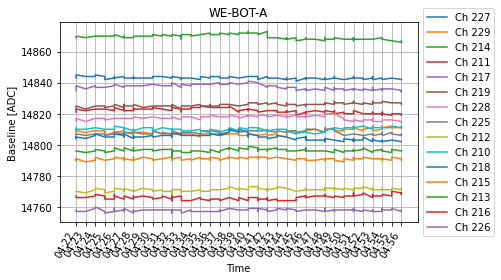

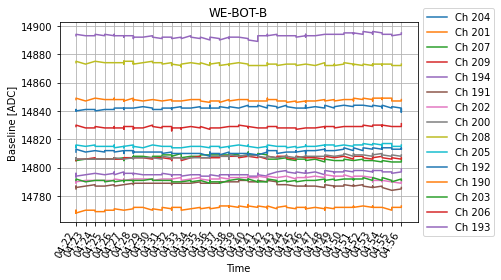

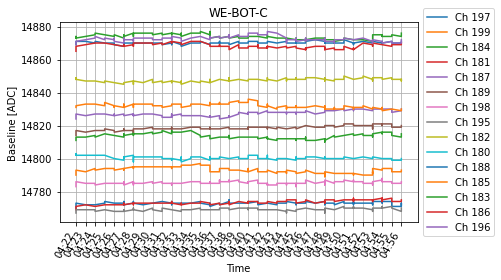

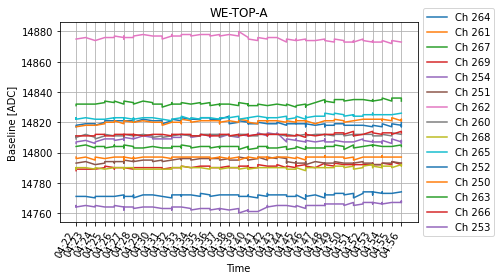

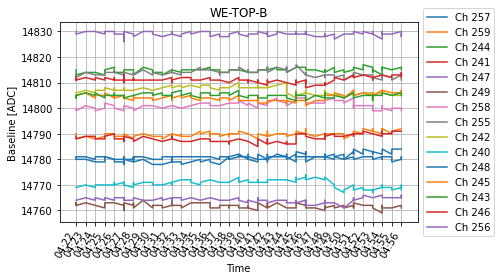

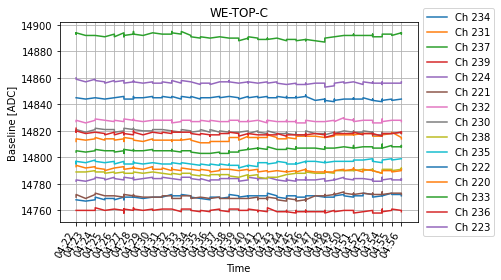

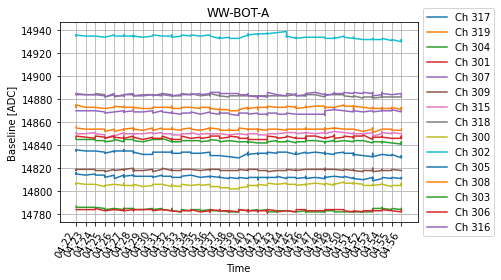

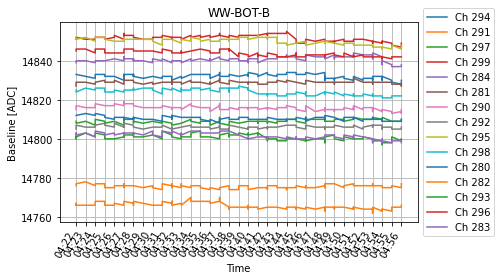

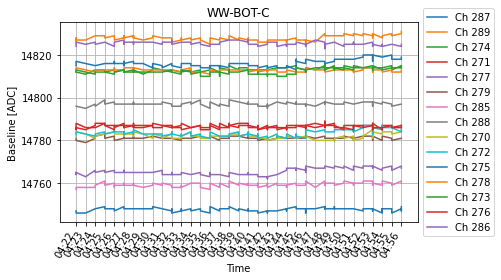

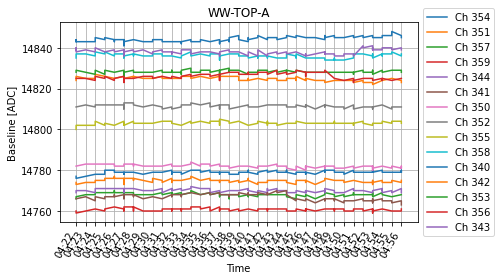

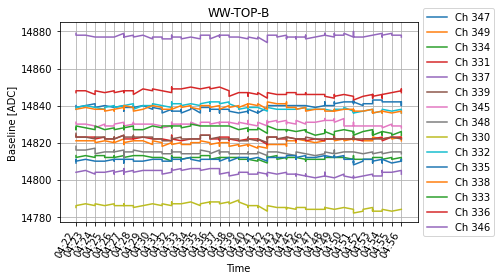

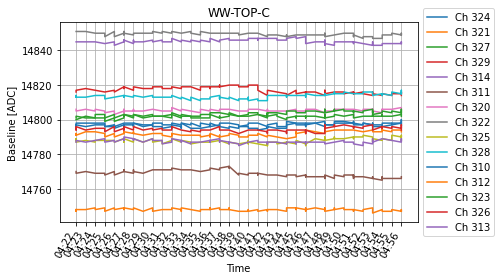

In [8]:
for board in boards:
    plot_baseline_evolution(meas_bs,db,board)

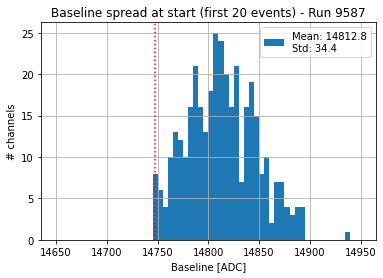

In [9]:
setting = 14747
xmin = 14650
xmax = 14950
xbins = 60
plot_baseline_spread(meas_bs, setting, run, xmax, xmin, xbins)